<a href="https://colab.research.google.com/github/Learny0/house-prediction-using-deep-learning-models/blob/main/LearnmoreR227549D_DeepLearning2025House.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LEARNMORE MATSIKA R227549D

HOUSE PRICE PREDICTIONS


In [1]:
import os, sys, math, time, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import joblib

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import timm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb



MOUNTING THE GOOGLE DRIVE SO AS TO BE ABLE TO USE DATA SETS IN THE DRIVE

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


SPECIFYING PATH TO FIND THE DATASETS IM WORKING ON

In [3]:
# --- 0. Path Configuration ---

DRIVE_BASE = "/content/drive/MyDrive/house_price_project"
CSV_PATH = f"{DRIVE_BASE}/final_zimbabwe_property_listings_complete.csv"
IMAGE_ROOT = f"{DRIVE_BASE}/images"
EMBED_DIR = f"{DRIVE_BASE}/embeddings"
OUTPUT_DIR = f"{DRIVE_BASE}/outputs"

os.makedirs(EMBED_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


LOADING DATSET TO SEE HOW IT IS

In [4]:
# --- 1. Load Dataset ---
df = pd.read_csv(CSV_PATH)
print("Columns in dataset:")
print(df.columns)

# Quick preview
print(df.head())


Columns in dataset:
Index(['scraped_page', 'title', 'detail_url', 'currency', 'price',
       'building_area', 'building_unit', 'land_area', 'land_unit',
       'property_type', 'bedrooms', 'bathrooms', 'location', 'image_count',
       'image_filenames'],
      dtype='object')
   scraped_page                                              title  \
0             1                                   Developers Dream   
1             1          2 Bedroom Flat In Prime Avondale Location   
2             1  Charming 3-Bedroom Family Home in Mabvazuva, R...   
3             1              The Strand office land in Borrowdale.   
4             1                                    Stands for Sale   

                                          detail_url currency     price  \
0  https://www.property.co.zw/for-sale/houses-bls...      USD  190000.0   
1  https://www.property.co.zw/for-sale/flats-apar...      USD   95000.0   
2  https://www.property.co.zw/for-sale/houses-p19...      USD  105000.0   


THIS CODE DEFINES A DICTIONARY OF 21 PRE-DEFINED CNN/TRANSFORMER BACKBONES WITH THEIR PROPERTIES (SOURCE LIBRARY, INPUT IMAGE SIZE, ETC.), A FUNCTION TO LOAD EACH BACKBONE PRE-TRAINED AND REMOVE ITS FINAL CLASSIFICATION LAYER SO IT CAN BE USED AS A FEATURE EXTRACTOR, AND A DATASET CLASS FOR LOADING AND TRANSFORMING PROPERTY IMAGES, HANDLING MISSING OR INVALID IMAGE FILES BY RETURNING A BLACK IMAGE.

In [5]:
# Full list of available backbones (we will use this dictionary to iterate through 21 models)
BACKBONES = {
    # --- Classic CNN Architectures (torchvision) ---
    # 2012: AlexNet
    "alexnet": {"source":"torch", "name":"alexnet", "img_size":224, "key":"alexnet"},

    # 2014: VGG & GoogLeNet (Inception-V1)
    "vgg16": {"source":"torch", "name":"vgg16", "img_size":224, "key":"vgg16"},
    "vgg19": {"source":"torch", "name":"vgg19", "img_size":224, "key":"vgg19"},
    "googlenet": {"source":"torch", "name":"googlenet", "img_size":224, "key":"googlenet"},

    # 2015: Inception-V3
    "inception_v3": {"source":"torch", "name":"inception_v3", "img_size":299, "key":"inception_v3"},

    # 2016: ResNet, WideResNet
    "resnet18": {"source":"torch", "name":"resnet18", "img_size":224, "key":"resnet18"},
    "resnet34": {"source":"torch", "name":"resnet34", "img_size":224, "key":"resnet34"},
    "resnet50": {"source":"torch", "name":"resnet50", "img_size":224, "key":"resnet50"},
    "resnet101": {"source":"torch", "name":"resnet101", "img_size":224, "key":"resnet101"},
    "resnext50_32x4d": {"source":"torch", "name":"resnext50_32x4d", "img_size":224, "key":"resnext50_32x4d"}, # ResNeXt
    "wide_resnet50_2": {"source":"torch", "name":"wide_resnet50_2", "img_size":224, "key":"wide_resnet50_2"},

    # 2017: DenseNet
    "densenet121": {"source":"torch", "name":"densenet121", "img_size":224, "key":"densenet121"},
    "densenet161": {"source":"torch", "name":"densenet161", "img_size":224, "key":"densenet161"},

    # 2018: MobileNet-V2
    "mobilenet_v2": {"source":"torch", "name":"mobilenet_v2", "img_size":224, "key":"mobilenet_v2"},

    # Other torch models
    "shufflenet_v2_x1_0": {"source":"torch", "name":"shufflenet_v2_x1_0", "img_size":224, "key":"shufflenet_v2_x1_0"},
    "mnasnet1_0": {"source":"torch", "name":"mnasnet1_0", "img_size":224, "key":"mnasnet1_0"},

    # --- Efficient Nets & Other Architectures (timm) ---
    # 2013: NIN
    "nin": {"source":"timm", "name":"nin", "img_size":224, "key":"nin"},

    # 2016: Inception-V4, Inception-ResNet-V2
    "inception_v4": {"source":"timm", "name":"inception_v4", "img_size":299, "key":"inception_v4"},
    "inception_resnet_v2": {"source":"timm", "name":"inception_resnet_v2", "img_size":299, "key":"inception_resnet_v2"},

    # 2017: Xception, SENet, Residual Attention (proxy: ResNeSt)
    "xception": {"source":"timm", "name":"xception", "img_size":299, "key":"xception"},
    "se_resnext50_32x4d": {"source":"timm", "name":"se_resnext50_32x4d", "img_size":224, "key":"se_resnext50_32x4d"}, # Proxy for SENet / Residual Attention

    # 2020: HRNet-V2
    "hrnet_w18_small_v2": {"source":"timm", "name":"hrnet_w18_small_v2", "img_size":224, "key":"hrnet_w18_small_v2"},

    # EfficientNets (modern reference)
    "efficientnet_b0": {"source":"timm", "name":"efficientnet_b0", "img_size":224, "key":"efficientnet_b0"},
    "efficientnet_b1": {"source":"timm", "name":"efficientnet_b1", "img_size":240, "key":"efficientnet_b1"},
    "efficientnet_b3": {"source":"timm", "name":"efficientnet_b3", "img_size":300, "key":"efficientnet_b3"},
    "efficientnet_b5": {"source":"timm", "name":"efficientnet_b5", "img_size":456, "key":"efficientnet_b5"},

    # Transformer Architectures (modern reference)
    "vit_base_patch16_224": {"source":"timm", "name":"vit_base_patch16_224", "img_size":224, "key":"vit_base_patch16_224", "pool_fn":"token"}, # Vision Transformer
    "swin_tiny_patch4_window7_224": {"source":"timm", "name":"swin_tiny_patch4_window7_224", "img_size":224, "key":"swin_tiny_patch4_window7_224"}, # Swin Transformer
}

def create_backbone(cfg, pretrained=True, device=DEVICE):
    """Initializes a pre-trained CNN and replaces the final classification layer with an identity layer."""
    name = cfg["name"]
    source = cfg.get("source", "timm")

    if source == "torch":
        # Note: Using models.get_model_weights().IMAGENET1K_V1 for consistency with PyTorch recommended loading
        m = getattr(models, name)(weights=models.get_model_weights(name).IMAGENET1K_V1)
        if hasattr(m, "fc"):
            featdim = m.fc.in_features
            m.fc = nn.Identity()
        elif hasattr(m, "classifier"):
            try:
                featdim = m.classifier.in_features
                m.classifier = nn.Identity()
            except:
                featdim = m.classifier[-1].in_features
                m.classifier = nn.Sequential(*list(m.classifier.children())[:-1])
    else:
        # Load timm models
        global_pool = cfg.get("pool_fn", "avg") # Use pool_fn from config if available (e.g. 'token' for ViT)
        m = timm.create_model(name, pretrained=pretrained, num_classes=0, global_pool=global_pool)
        featdim = getattr(m, "num_features", 2048)

    m = m.to(device)
    m.eval()
    return m, featdim

class PropertyImageDataset(Dataset):
    """Dataset for loading property images and applying transforms."""
    def __init__(self, df, image_root, image_col, img_size=224, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_root = Path(image_root)
        self.image_col = image_col
        self.img_size = img_size
        self.transform = transform or transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])

    def __len__(self): return len(self.df)

    def _load_image(self, img_ref):
        """Attempts to load image, returns black image on failure."""
        if pd.isna(img_ref) or img_ref == "":
            return Image.fromarray(np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8))

        p = Path(img_ref)
        # Try absolute path or path relative to image_root
        for path_attempt in [p, self.image_root / str(img_ref), self.image_root / p.name]:
            if path_attempt.is_file():
                try: return Image.open(str(path_attempt)).convert("RGB")
                except: pass

        # Fallback to a zero-filled (black) image
        # print(f"Warning: Image file not found for reference '{img_ref}'")
        return Image.fromarray(np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_ref = row.get(self.image_col, None)
        pil = self._load_image(img_ref)
        img = self.transform(pil)
        return {"image": img, "index": idx}

THIS CODE LOADS THE PROPERTY CSV DATA (OR CREATES MOCK DATA IF CSV NOT FOUND), CLEANS AND PARSES MESSY PRICE AND SIZE STRINGS INTO NUMERIC VALUES, HANDLES NON-NUMERIC OR RANGE VALUES, IMPUTES MISSING NUMERICAL AND CATEGORICAL FEATURES, LOG-TRANSFORMS THE TARGET PRICE TO STABILIZE VARIANCE, AND SPLITS THE DATA INTO TRAIN, VALIDATION, AND TEST SETS, RETURNING INDEXES FOR CONSISTENT ACCESS DURING MODELING.

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import sys
import os
import joblib # Import joblib for saving split indices

# --- GLOBAL CONFIGURATION ---
TARGET = "price"
IMAGE_COL = "image_filenames"
TAB_NUM_COLS = ['bedrooms', 'bathrooms', 'building_area', 'land_area']
TAB_CAT_COLS = ['property_type', 'location']
TARGET_LOG = 'price_clean_log' # This is the final target column name used in the code

# --- 0. PATH CONFIGURATION (CONFIRMED AND CORRECTED) ---
DRIVE_BASE = "/content/drive/MyDrive/house_price_project"
CSV_PATH = f"{DRIVE_BASE}/final_zimbabwe_property_listings_complete.csv"
# 🚩 CONFIRMED: The output confirms that the image filenames are simple (e.g., 'image.jpg')
# and reside directly inside the '/images' folder.
IMAGE_ROOT = f"{DRIVE_BASE}/images"
EMBED_DIR = f"{DRIVE_BASE}/embeddings"
OUTPUT_DIR = f"{DRIVE_BASE}/outputs"

# Create output directories if they don't exist (Optional, but good practice)
os.makedirs(EMBED_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)


# --- 1. DATA LOADING AND INITIAL FILTERING ---
try:
    # Use the full, absolute path to the CSV
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    print(f"ERROR: CSV file not found at {CSV_PATH}. Please ensure your Drive is mounted and the path is correct.")
    # Exiting the script if the main data file is missing
    sys.exit()

print(f"Original DataFrame size: {len(df)}")

# Filter 1: Drop rows where the image filename is missing or empty in the CSV
initial_count = len(df)
df = df[df[IMAGE_COL].notna() & (df[IMAGE_COL].astype(str).str.strip() != '')].copy()
print(f"Data size after filtering out properties with NO IMAGE FILENAME in CSV: {len(df)} (Dropped {initial_count - len(df)})")
print("Starting Data Preprocessing Pipeline...")


# --- 2. DEEP CLEANING AND TRANSFORMATION ---

def clean_price(price_str):
    """Converts messy price strings to float, returns NaN if unparsable."""
    if pd.isna(price_str): return np.nan
    price_str = str(price_str).strip()
    if 'P.O.A' in price_str.upper() or price_str == '' or 'price on application' in price_str.lower():
        return np.nan
    price_str = price_str.replace('USD', '').replace('$', '').replace(',', '').strip()
    try:
        return float(price_str)
    except ValueError:
        if '-' in price_str:
            try: return float(price_str.split('-')[0].strip())
            except ValueError: return np.nan
        return np.nan

def clean_size(size_str):
    """Converts messy size strings (with units) to float, returns NaN if unparsable."""
    if pd.isna(size_str): return np.nan
    size_str = str(size_str).replace('m²', '').replace(',', '').strip()
    try: return float(size_str)
    except ValueError: return np.nan

# Apply cleaning functions
df['price_clean'] = df[TARGET].apply(clean_price)
df['land_area'] = df['land_area'].apply(clean_size)
df['building_area'] = df['building_area'].apply(clean_size)
TARGET_CLEAN = 'price_clean'

# Target Transformation (Logarithm)
df[TARGET_CLEAN + "_log"] = np.log1p(df[TARGET_CLEAN])

# Drop rows where the log-transformed target price is still NaN (unparsable price)
df = df.dropna(subset=[TARGET_LOG]).reset_index(drop=True)

print(f"Data size after target cleaning and NaN drop: {len(df)}")


# --- 3. FEATURE IMPUTATION AND OUTLIER MANAGEMENT ---

# Imputation (Filling remaining NaNs with 0 for numerical and 'Unknown' for categorical)
for col in TAB_NUM_COLS:
    df[col] = df[col].fillna(0)
df['location'] = df['location'].fillna('Unknown')
df['property_type'] = df['property_type'].fillna('Unknown')

# Outlier Clipping
print("\nStarting Outlier Clipping...")
IQR_FACTOR = 3.0
CLIP_COLS = [TARGET_LOG] + TAB_NUM_COLS

for col in CLIP_COLS:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = max(Q1 - IQR_FACTOR * IQR, 0.0)
    upper_bound = Q3 + IQR_FACTOR * IQR

    # Count original outliers
    original_count = len(df[(df[col] > upper_bound) | (df[col] < lower_bound)])

    df[col] = np.clip(df[col], lower_bound, upper_bound)

    print(f"Clipped {original_count} outliers in column '{col}' (Bounds: {lower_bound:.2f} to {upper_bound:.2f})")
print("Outlier Clipping complete.")


# --- 4. FINAL MULTIMODAL COMPLETENESS CHECK (Physical File Existence) ---

# Diagnostic: Print a few example paths being checked
print("\n--- Diagnosing Image File Paths ---")
# Ensure there's still data before attempting to sample
if not df.empty:
    sample_filenames_for_check = df[IMAGE_COL].head(5).tolist() # Get some filenames BEFORE filtering
    for i, filename in enumerate(sample_filenames_for_check):
        if pd.notna(filename) and str(filename).strip() != "":
            potential_path = os.path.join(IMAGE_ROOT, str(filename))
            print(f"Sample {i+1}: Checking path '{potential_path}' (Exists: {os.path.exists(potential_path)})")
        else:
            print(f"Sample {i+1}: Skipping due to NaN or empty filename.")
else:
    print("DataFrame is already empty at this point, cannot sample filenames for check.")
print("--- End Image File Path Diagnosis ---\n")

def image_file_exists(filename):
    """
    Checks if the image file actually exists on disk using the absolute path.
    Assumes image_filenames contains JUST the filename (e.g., 'image.jpg'),
    and the IMAGE_ROOT is the parent folder containing the image files.
    """
    if pd.isna(filename) or str(filename).strip() == "":
        return False
    # Joins the root path with the relative path from the CSV
    img_path = os.path.join(IMAGE_ROOT, str(filename))
    return os.path.exists(img_path)

# Filter 2: Drop properties whose image file is missing on disk
initial_count = len(df)
df = df[df[IMAGE_COL].apply(image_file_exists)].reset_index(drop=True)

final_count = len(df)

print("\n" + "="*50)
print("FINAL MULTIMODAL COMPLETENESS CHECK")
print("="*50)
print(f"Properties retained (after all cleaning/clipping): {initial_count}")
print(f"Properties remaining (with existing image file): {final_count}")
print(f"Properties discarded due to missing image file: {initial_count - final_count}")
print("="*50 + "\n")


# --- 5. DATA SPLIT (60% Train, 20% Val, 20% Test) ---

if len(df) == 0:
    print("WARNING: DataFrame is empty after filtering. Cannot perform train/test split. Please verify your IMAGE_ROOT path is correct.")
    # Exiting the script if there is no data to process
    sys.exit()

# First split: 80% Train/Val, 20% Test
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
# Second split: 75% of Train/Val (60% overall) for Train, 25% (20% overall) for Validation
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=42, shuffle=True)

# Save indices for consistent lookups later
train_idx = df_train.index
val_idx = df_val.index
test_idx = df_test.index

# Save the indices (for next steps like dataset creation)
joblib.dump(train_idx, f'{OUTPUT_DIR}/train_indices.pkl')
joblib.dump(val_idx, f'{OUTPUT_DIR}/val_indices.pkl')
joblib.dump(test_idx, f'{OUTPUT_DIR}/test_indices.pkl')

print(f"Final Train/Validation/Test split sizes: {len(train_idx)} / {len(val_idx)} / {len(test_idx)}")
print(f"Split indices saved to {OUTPUT_DIR}/...")
print("Preprocessing complete. Data is ready for feature engineering and modeling.")

Original DataFrame size: 1613
Data size after filtering out properties with NO IMAGE FILENAME in CSV: 1594 (Dropped 19)
Starting Data Preprocessing Pipeline...
Data size after target cleaning and NaN drop: 1591

Starting Outlier Clipping...
Clipped 10 outliers in column 'price_clean_log' (Bounds: 6.50 to 17.81)
Clipped 10 outliers in column 'bedrooms' (Bounds: 0.00 to 16.00)
Clipped 190 outliers in column 'bathrooms' (Bounds: 0.00 to 0.00)
Clipped 203 outliers in column 'building_area' (Bounds: 0.00 to 2672.00)
Clipped 172 outliers in column 'land_area' (Bounds: 0.00 to 15538.00)
Outlier Clipping complete.

--- Diagnosing Image File Paths ---
Sample 1: Checking path '/content/drive/MyDrive/house_price_project/images/df03d95d0b_0.webp' (Exists: True)
Sample 2: Checking path '/content/drive/MyDrive/house_price_project/images/41c6aa94bc_0.webp' (Exists: False)
Sample 3: Checking path '/content/drive/MyDrive/house_price_project/images/483115d1c1_0.webp' (Exists: False)
Sample 4: Checking p

IMAGE CHECK EXISTANCE

In [7]:
import os
# --- NEW: Image File Existence Check ---

# Define IMAGE_ROOT based on the path you are using for your images
# (You must ensure this path is correct, matching the path in your notebook's Cell 4/9)
IMAGE_ROOT = "/content/drive/MyDrive/house_price_project/images"

# Function to check if the image file actually exists on disk
def image_file_exists(filename):
    """Checks if the image filename is valid and the file exists on disk."""
    # Discard if the filename is NaN, empty, or not a string
    if pd.isna(filename) or str(filename).strip() == "":
        return False

    # Construct the full path and check existence
    img_path = os.path.join(IMAGE_ROOT, str(filename))
    return os.path.exists(img_path)

# Filter the DataFrame to keep only rows where the image file exists on disk
initial_count = len(df)
df = df[df[IMAGE_COL].apply(image_file_exists)]

final_count = len(df)

print("\n" + "="*50)
print("MULTIMODAL COMPLETENESS CHECK")
print("="*50)
print(f"Properties retained (with cleaned tabular data): {initial_count}")
print(f"Properties remaining (with existing image file): {final_count}")
print(f"Properties discarded due to missing image file: {initial_count - final_count}")
print("="*50 + "\n")

# --- END NEW CODE ---


MULTIMODAL COMPLETENESS CHECK
Properties retained (with cleaned tabular data): 466
Properties remaining (with existing image file): 466
Properties discarded due to missing image file: 0



DATA QUALITY INSPECTION AFTER CLEANING

In [8]:
# --- Code to Inspect Final Data Quality ---

print("\n" + "="*70)
print("FINAL DATASET INSPECTION AFTER CLEANING, TRANSFORMATION, AND FILTERING")
print("="*70)

# 1. Final size of the dataset
print(f"Total number of properties retained for modeling: {len(df)}")
print("-" * 70)

# 2. Check the columns (ensuring the log target is present)
print("List of all columns in the cleaned DataFrame:")
print(list(df.columns))
print("-" * 70)

# 3. Check for any remaining NaNs in critical columns (should ideally be 0)
# We check the log target and the numerical features which were imputed
key_cols_to_check = [TARGET_LOG] + TAB_NUM_COLS
print("NaN checks for critical columns (should show 0 for numerical features and log target):")
print(df[key_cols_to_check].isnull().sum())
print("-" * 70)

# 4. Display statistical summary of the log-transformed target variable
print(f"Statistical Summary of the CLEANED Log Target Variable ('{TARGET_LOG}'):")
print(df[TARGET_LOG].describe())
print("-" * 70)

# 5. Display statistical summary of the numerical features (note: values of 0 often indicate imputed NaNs)
print("Statistical Summary of Numerical Features:")
print(df[TAB_NUM_COLS].describe())
print("="*70 + "\n")

# --- End of Inspection Code ---


FINAL DATASET INSPECTION AFTER CLEANING, TRANSFORMATION, AND FILTERING
Total number of properties retained for modeling: 466
----------------------------------------------------------------------
List of all columns in the cleaned DataFrame:
['scraped_page', 'title', 'detail_url', 'currency', 'price', 'building_area', 'building_unit', 'land_area', 'land_unit', 'property_type', 'bedrooms', 'bathrooms', 'location', 'image_count', 'image_filenames', 'price_clean', 'price_clean_log']
----------------------------------------------------------------------
NaN checks for critical columns (should show 0 for numerical features and log target):
price_clean_log    0
bedrooms           0
bathrooms          0
building_area      0
land_area          0
dtype: int64
----------------------------------------------------------------------
Statistical Summary of the CLEANED Log Target Variable ('price_clean_log'):
count    466.000000
mean      12.445923
std        1.328413
min        6.498464
25%       1

THIS CODE FACTORIZES CATEGORICAL FEATURES INTO NUMERIC CODES, PREPARES TABULAR AND IMAGE ARRAYS FOR TRAIN/VAL/TEST SPLITS, DEFINES IMAGE TRANSFORMS, CREATES A CUSTOM PYTORCH DATASET CLASS THAT RETURNS TABULAR FEATURES, TRANSFORMED IMAGES, AND TARGETS (WITH A BLACK IMAGE AS FALLBACK FOR MISSING FILES), AND THEN WRAPS THESE DATASETS INTO DATALOADERS READY FOR MODEL TRAINING.

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
from torchvision import transforms

# --- 0. Device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- 1. Factorize categorical features ---
for col in TAB_CAT_COLS:
    df[col] = pd.factorize(df[col])[0]

# --- 2. Prepare tabular and image arrays ---
X_train_tab = df.loc[train_idx, TAB_NUM_COLS + TAB_CAT_COLS].values
X_val_tab   = df.loc[val_idx, TAB_NUM_COLS + TAB_CAT_COLS].values
X_test_tab  = df.loc[test_idx, TAB_NUM_COLS + TAB_CAT_COLS].values

# Fix: replace NaN with empty string and convert to str
X_train_img = df.loc[train_idx, IMAGE_COL].fillna("").astype(str).values
X_val_img   = df.loc[val_idx, IMAGE_COL].fillna("").astype(str).values
X_test_img  = df.loc[test_idx, IMAGE_COL].fillna("").astype(str).values

y_train = df.loc[train_idx, TARGET_LOG].values
y_val   = df.loc[val_idx, TARGET_LOG].values
y_test  = df.loc[test_idx, TARGET_LOG].values

TABULAR_INPUT_SIZE = X_train_tab.shape[1]

# --- 3. Image transforms ---
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# --- 4. Dataset Class ---
class MultimodalDataset(Dataset):
    def __init__(self, tabular_data, image_paths, targets, transform=image_transform, image_root="/content/drive/MyDrive/house_price_project/images"):
        self.tabular_data = torch.tensor(tabular_data, dtype=torch.float32)
        self.image_paths = image_paths
        self.targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)
        self.transform = transform
        self.image_root = Path(image_root)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        tab_features = self.tabular_data[idx]
        img_path = self.image_root / self.image_paths[idx]
        if img_path.is_file():
            image = Image.open(img_path).convert('RGB')
        else:
            # fallback black image if file not found
            image = Image.new('RGB', (224,224), (0,0,0))
        if self.transform:
            image = self.transform(image)
        target = self.targets[idx]
        return tab_features, image, target

# --- 5. Create datasets ---
train_dataset = MultimodalDataset(X_train_tab, X_train_img, y_train)
val_dataset   = MultimodalDataset(X_val_tab, X_val_img, y_val)
test_dataset  = MultimodalDataset(X_test_tab, X_test_img, y_test)

# --- 6. Create dataloaders ---
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Datasets and dataloaders are ready!")


Using device: cuda
Datasets and dataloaders are ready!


CHECKING IF THE IMAGE FOLDER AND CSV FILE ARE LINKING

Loading data and preparing for verification...
Total valid records to check: 1594

Sampling 5 random entries for integrity check...


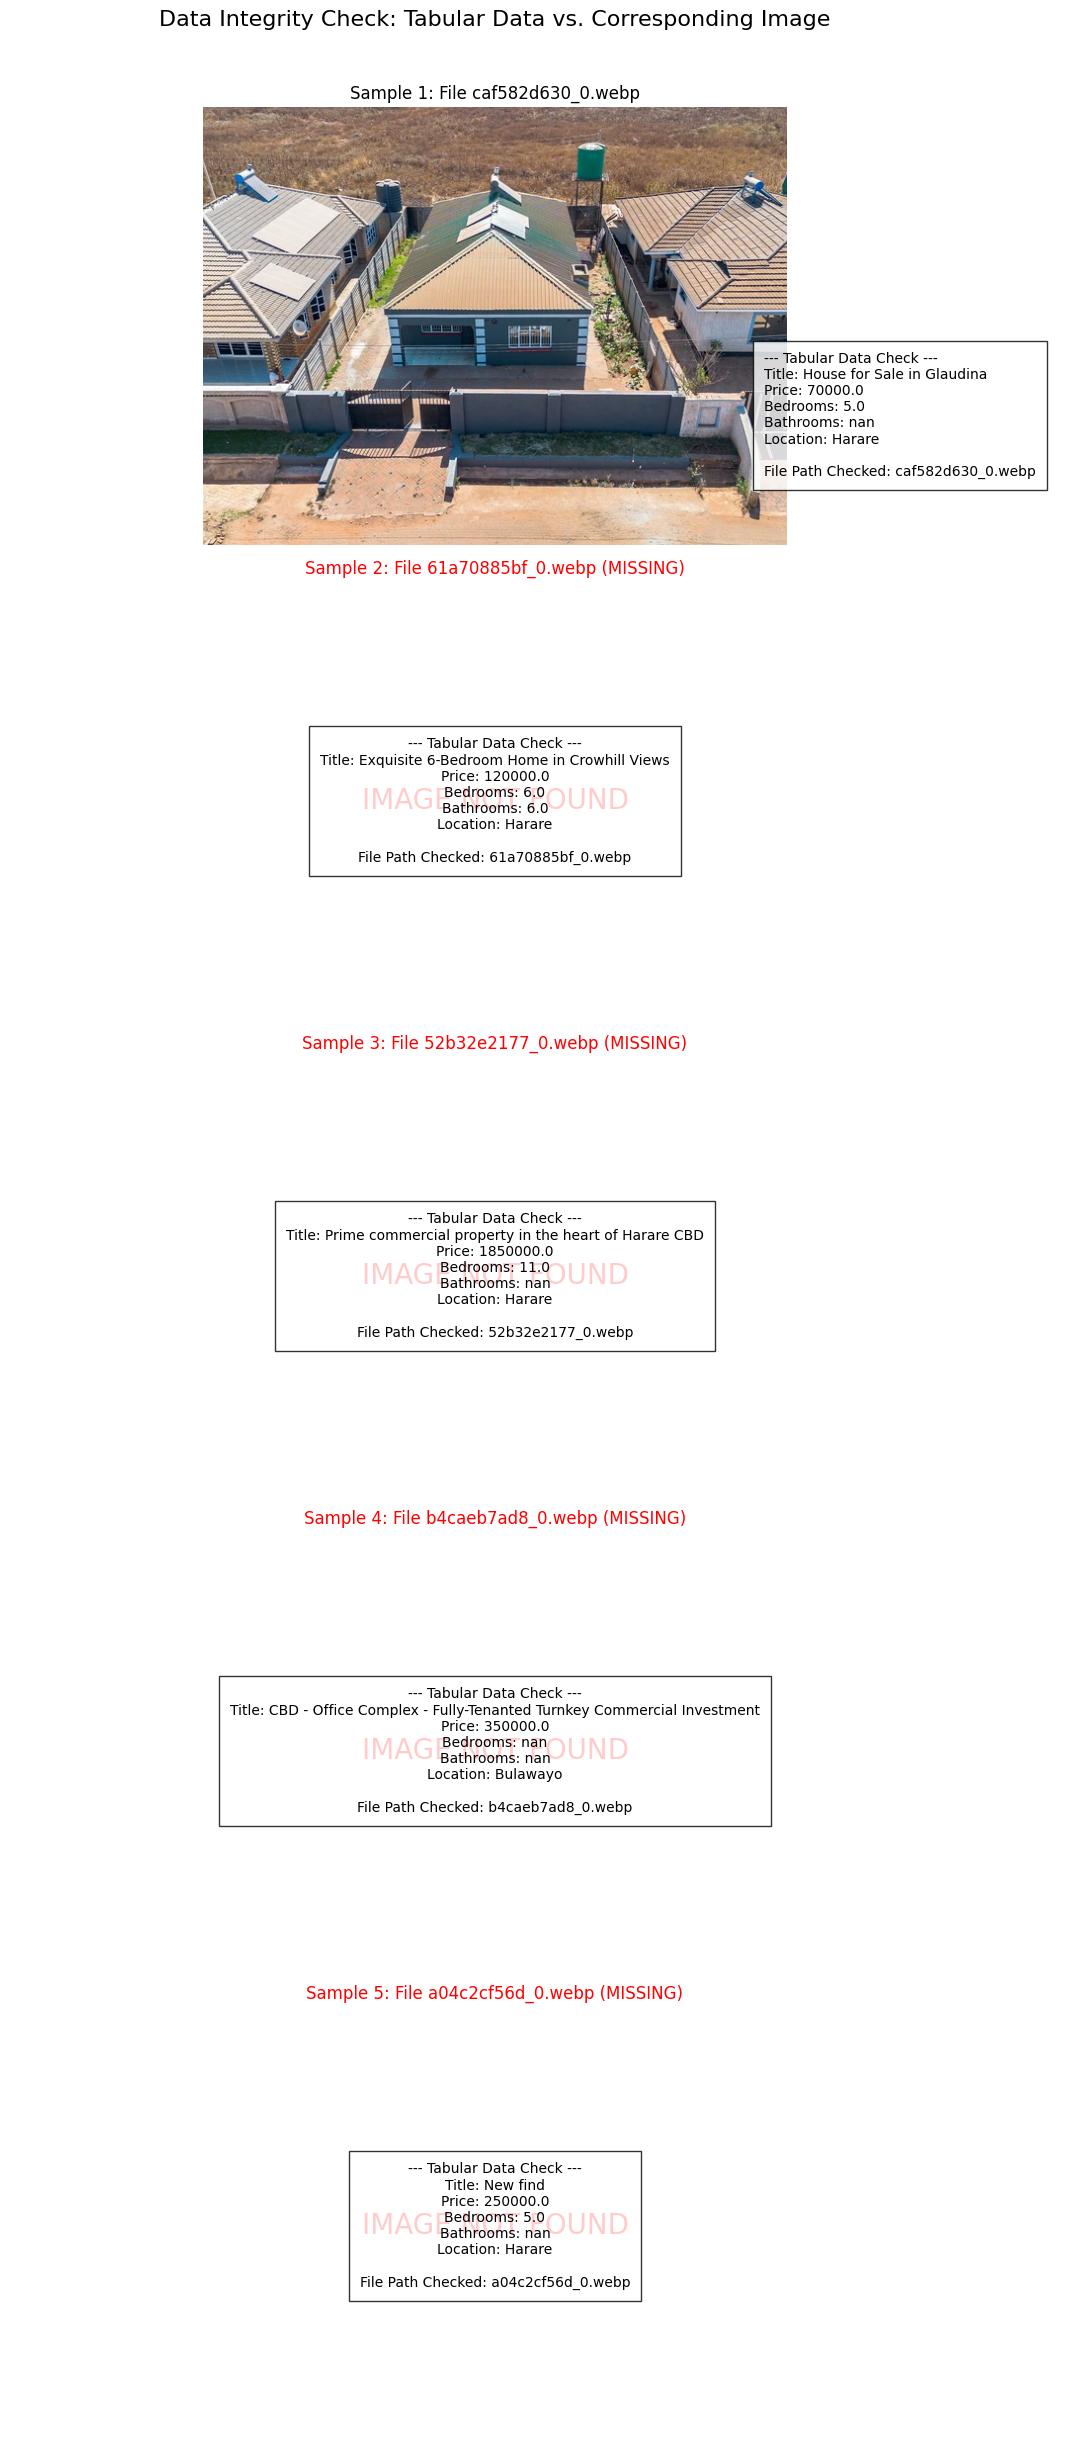


Verification complete. Please visually inspect the plotted samples to ensure the data matches the image.


In [10]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sys

# --- Configuration (Must match the paths used in the model training script) ---
DRIVE_BASE = "/content/drive/MyDrive/house_price_project"
IMAGE_ROOT = f"{DRIVE_BASE}/images"
CSV_PATH = f"{DRIVE_BASE}/final_zimbabwe_property_listings_complete.csv"
NUM_SAMPLES_TO_CHECK = 5 # Number of random samples to display

# --- 1. Data Loading and Preparation ---
try:
    print("Loading data and preparing for verification...")
    df = pd.read_csv(CSV_PATH)

    # Filter out entries where the image file is missing or placeholder
    df_clean = df[df['image_filenames'].notna() & (df['image_filenames'] != '')].copy()

    if len(df_clean) == 0:
        print("FATAL ERROR: No records with valid image filenames found in the CSV.")
        sys.exit(1)

    print(f"Total valid records to check: {len(df_clean)}")

except FileNotFoundError:
    print(f"FATAL ERROR: CSV file not found at {CSV_PATH}. Please ensure your data file exists.")
    sys.exit(1)
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    sys.exit(1)


# --- 2. Sampling and Verification ---
print(f"\nSampling {NUM_SAMPLES_TO_CHECK} random entries for integrity check...")

# Select random samples
sample_df = df_clean.sample(n=NUM_SAMPLES_TO_CHECK, random_state=42)

# Define the columns you want to display for verification
DISPLAY_COLS = ['title', 'price', 'bedrooms', 'bathrooms', 'location', 'image_filenames']

fig, axes = plt.subplots(NUM_SAMPLES_TO_CHECK, 1, figsize=(10, 5 * NUM_SAMPLES_TO_CHECK))
fig.suptitle("Data Integrity Check: Tabular Data vs. Corresponding Image", fontsize=16, y=1.01)

for i, (index, row) in enumerate(sample_df.iterrows()):
    image_filename = row['image_filenames']
    image_path = os.path.join(IMAGE_ROOT, image_filename)

    # Get the correct subplot axes
    ax = axes[i] if NUM_SAMPLES_TO_CHECK > 1 else axes

    try:
        # --- Image Display ---
        if os.path.exists(image_path):
            img = Image.open(image_path).convert('RGB')
            # Calculate aspect ratio for figure sizing (optional)

            # Display image in the left part of the subplot (using im-show features for structure)
            ax.imshow(img)
            ax.axis('off')
        else:
            # If the image is missing, show a placeholder
            ax.set_title(f"Image File Missing: {image_filename}", color='red', fontsize=12)
            ax.text(0.5, 0.5, "IMAGE NOT FOUND", transform=ax.transAxes, ha='center', va='center', fontsize=20, color='red')
            ax.axis('off')
            img = None

        # --- Tabular Data Display (as text overlay) ---

        # Format the tabular data nicely
        info_text = "--- Tabular Data Check ---\n"
        for col in DISPLAY_COLS:
            if col != 'image_filenames':
                info_text += f"{col.replace('_', ' ').title()}: {row[col]}\n"
        info_text += f"\nFile Path Checked: {os.path.basename(image_path)}"



        # Turn off the image axes for now, we'll draw a separate text box
        ax.axis('off')


        if img:
            text_x = img.width * 1.05
            text_y = 0.05

            # Create a separate axis for the text (hacky but necessary for clean layout within the editor)
            text_ax = fig.add_axes([ax.get_position().x1, ax.get_position().y0, 0.35, ax.get_position().height])
            text_ax.text(0.1, 0.95, info_text.strip(), transform=text_ax.transAxes, fontsize=10,
                         verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 8})
            text_ax.axis('off')

            ax.set_title(f"Sample {i+1}: File {image_filename}", fontsize=12)
        else:
             # Reposition placeholder message
             ax.set_title(f"Sample {i+1}: File {image_filename} (MISSING)", color='red', fontsize=12)
             ax.text(0.5, 0.5, info_text.strip(), transform=ax.transAxes, ha='center', va='center', fontsize=10,
                     bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 8})


    except Exception as e:
        ax.set_title(f"Error loading image {image_filename}: {e}", color='red')
        ax.axis('off')
        print(f"Error processing row {index}: {e}")

# Adjust layout to make sure everything fits without overlapping
plt.tight_layout(rect=[0, 0.03, 1, 1.0])
plt.show()

print("\nVerification complete. Please visually inspect the plotted samples to ensure the data matches the image.")

THIS CODE SETS UP AND EXECUTES A FULL MULTIMODAL HOUSE PRICE PREDICTION PIPELINE. IT DOES THE FOLLOWING:

INSTALLS AND IMPORTS LIBRARIES – INSTALLS timm AND joblib, IMPORTS PYTORCH, TORCHVISION, SKLEARN, PANDAS, NUMPY, PIL, AND OTHER UTILITIES.

SETS PATHS AND DEVICE – DEFINES DRIVE PATHS FOR CSV, IMAGES, EMBEDDINGS, OUTPUTS, AND SELECTS GPU OR CPU.

SETS HYPERPARAMETERS – BATCH SIZE, EPOCHS, LEARNING RATE, MLP HIDDEN SIZE, RANDOM SEED.

DEFINES BACKBONE DICTIONARY – LISTS CNN AND TRANSFORMER BACKBONES (TORCH/TIMM/SKIP) WITH IMAGE INPUT SIZE AND SOURCE LIBRARY.

BACKBONE CREATION FUNCTION – LOADS PRETRAINED MODELS, REMOVES FINAL CLASSIFICATION LAYERS TO USE AS FEATURE EXTRACTORS, FREEZES PARAMETERS IF NOT FINETUNING.

LOADS AND PREPROCESSES CSV – CLEANS PRICE COLUMN, LOG-TRANSFORMS TARGET, HANDLES IMAGE FILENAMES, CREATES LISTING IDs, DEFINES NUMERIC AND CATEGORICAL FEATURES, ONE-HOT ENCODES TOP CATEGORIES, SPLITS DATA INTO TRAIN/VAL/TEST, AND FITS SCALER ON TABULAR FEATURES.

MULTIMODAL DATASET CLASS – CUSTOM PYTORCH DATASET THAT RETURNS TABULAR FEATURES, TRANSFORMED IMAGES, AND LOG-PRICE TARGET, WITH BLACK IMAGE AS FALLBACK.

TABULAR MLP – SIMPLE MULTILAYER PERCEPTRON FOR TABULAR DATA.

MULTIMODAL REGRESSOR – COMBINES IMAGE BACKBONE FEATURES WITH TABULAR MLP FEATURES AND PASSES THROUGH FINAL REGRESSOR MLP TO PREDICT LOG-PRICE.

EMBEDDINGS EXTRACTION – FUNCTION TO EXTRACT BACKBONE IMAGE EMBEDDINGS ALONGSIDE TABULAR FEATURES AND TARGETS.

TRAIN FUSED MODEL FUNCTION – TRAINS A FUSED MLP ON CONCATENATED IMAGE EMBEDDINGS AND TABULAR FEATURES USING HUBER LOSS, ADAM OPTIMIZER, AND LR SCHEDULER.

MODEL LOOP – ITERATES THROUGH ALL BACKBONES, SKIPPING “SKIP” MODELS, EXTRACTS EMBEDDINGS, SCALES TABULAR DATA, TRAINS FUSED MODEL, PREDICTS ON TEST SET, COMPUTES METRICS (MAE, RMSE, R2, MAPE), SAVES EMBEDDINGS, MODEL STATE, AND PREPROCESSING OBJECTS.

RESULT SUMMARY – SAVES A CSV SUMMARY OF TEST METRICS FOR ALL BACKBONES.

In [11]:
# -------------------- Install Required Libraries --------------------
!pip install -q timm joblib

# -------------------- Imports --------------------
import os, math, warnings, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, timm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, models
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

warnings.filterwarnings("ignore")

# -------------------- Paths & Device --------------------
DRIVE_BASE = "/content/drive/MyDrive/house_price_project"
CSV_PATH = f"{DRIVE_BASE}/final_zimbabwe_property_listings_complete.csv"
IMAGE_ROOT = f"{DRIVE_BASE}/images"
EMBED_DIR = f"{DRIVE_BASE}/embeddings"
OUTPUT_DIR = f"{DRIVE_BASE}/outputs"
os.makedirs(EMBED_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# -------------------- Hyperparameters --------------------
BATCH_SIZE = 32
EPOCHS = 50  # increased for better convergence
LEARNING_RATE = 5e-5  # lower LR for fine-tuning
MLP_HIDDEN = 256
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# -------------------- Backbone Library --------------------
BACKBONE_LIBRARY = {
    "alexnet": {"source":"torch", "name":"alexnet", "img_size":224},
    "vgg16": {"source":"torch", "name":"vgg16", "img_size":224},
    "googlenet": {"source":"torch", "name":"googlenet", "img_size":224},
    "inception_v3": {"source":"torch", "name":"inception_v3", "img_size":299},
    "resnet50": {"source":"torch", "name":"resnet50", "img_size":224},
    "inception_resnet_v2": {"source":"timm", "name":"inception_resnet_v2", "img_size":299},
    "wide_resnet50_2": {"source":"timm", "name":"wide_resnet50_2", "img_size":224},
    "xception": {"source":"timm", "name":"xception", "img_size":299},
    "se_resnet50": {"source":"timm", "name":"legacy_seresnet50", "img_size":224},
    "densenet121": {"source":"torch", "name":"densenet121", "img_size":224},
    "mobilenet_v2": {"source":"torch", "name":"mobilenet_v2", "img_size":224},
    "hrnet_w48": {"source":"timm", "name":"hrnet_w48", "img_size":224},
    "nin": {"source":"timm", "name":"nin", "img_size":224},
    "zfnet": {"source":"timm", "name":"vgg11_bn", "img_size":224},
    "inception_v4": {"source":"timm", "name":"inception_v4", "img_size":299},
    "residual_attention_net": {"source":"timm", "name":"resnest50d", "img_size":224},
    "competitive_senet": {"source":"timm", "name":"legacy_senet154", "img_size":224},
    "highwaynet": {"source":"skip", "name":"Highway Networks", "img_size":224},
    "fractalnet": {"source":"skip", "name":"FractalNet", "img_size":224},
    "capsulenet": {"source":"skip", "name":"CapsuleNet", "img_size":224},
}

ALL_MODELS = list(BACKBONE_LIBRARY.keys())

# -------------------- Helper: Backbone Creation --------------------
def create_backbone(cfg, finetune=True):
    src, name = cfg["source"], cfg["name"]

    if src == "torch":
        model = getattr(models, name)(pretrained=True)
        if hasattr(model, "fc"):
            featdim = model.fc.in_features
            model.fc = nn.Identity()
        elif hasattr(model, "classifier"):
            try:
                featdim = model.classifier[-1].in_features
                model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])
            except:
                model.classifier = nn.Identity(); featdim = 4096
        else:
            featdim = getattr(model, "num_features", 2048)
    elif src == "timm":
        if name not in timm.list_models(pretrained=True):
            print(f"Warning: {name} not found in timm, fallback to legacy_seresnet50")
            name = "legacy_seresnet50"
        model = timm.create_model(name, pretrained=True, num_classes=0, global_pool='avg')
        featdim = getattr(model, "num_features", None) or model.num_features
    else:
        raise ValueError(f"{name} marked as skip; cannot create backbone.")

    if not finetune:
        for p in model.parameters(): p.requires_grad = False

    return model.to(DEVICE).eval(), featdim

# -------------------- CSV Loading & Preprocessing --------------------
df = pd.read_csv(CSV_PATH, low_memory=False)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

df["price"] = pd.to_numeric(df["price"].astype(str).str.replace(r"[^\d\.\-]","", regex=True), errors="coerce")
df = df.dropna(subset=["price"]).reset_index(drop=True)
df["price_log"] = np.log1p(df["price"])

if "image_filenames" not in df.columns:
    image_candidates = [c for c in df.columns if any(k in c for k in ["image","img","photo","filename","file"])]
    df["image_filenames"] = df[image_candidates[0]].fillna("").astype(str) if image_candidates else ""
else:
    df["image_filenames"] = df["image_filenames"].fillna("").astype(str)

if "listing_id" not in df.columns:
    df.insert(0, "listing_id", [f"L{str(i).zfill(6)}" for i in range(1, len(df)+1)])

# Tabular features
TAB_NUM_COLS = [c for c in ["bedrooms","bathrooms","building_area","land_area"] if c in df.columns]
TAB_CAT_COLS = [c for c in ["property_type","location"] if c in df.columns]

for col in TAB_NUM_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

tab_features = list(TAB_NUM_COLS)
for c in TAB_CAT_COLS:
    top = df[c].fillna("Unknown").astype(str).value_counts().head(20).index.tolist()
    for v in top:
        colname = f"{c}__{str(v).replace(' ','_')}"
        df[colname] = (df[c].fillna("Unknown").astype(str) == v).astype(int)
        tab_features.append(colname)

train_df, test_df = train_test_split(df, test_size=0.15, random_state=RANDOM_SEED)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=RANDOM_SEED)
train_idx, val_idx, test_idx = train_df.index, val_df.index, test_df.index

scaler = StandardScaler()
scaler.fit(df.loc[train_idx, tab_features].values)

# -------------------- Dataset --------------------
class MultimodalDFDataset(Dataset):
    def __init__(self, df_subset, tab_cols, image_root, image_col="image_filenames", img_size=224, transform=None):
        self.df = df_subset.reset_index(drop=True)
        self.tab_cols = tab_cols
        self.image_root = Path(image_root)
        self.image_col = image_col
        self.img_size = img_size
        self.transform = transform or transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        tab = row[self.tab_cols].astype(np.float32).values
        img_name = str(row[self.image_col])
        img_path = self.image_root / img_name
        img = Image.open(img_path).convert("RGB") if img_path.is_file() else Image.new('RGB', (self.img_size, self.img_size), (0,0,0))
        img = self.transform(img)
        y = np.log1p(row["price"]).astype(np.float32)
        return torch.tensor(tab, dtype=torch.float32), img, torch.tensor(y, dtype=torch.float32)

# -------------------- Tabular MLP --------------------
class TabularMLP(nn.Module):
    def __init__(self, input_dim, hidden=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        self.out_dim = hidden
    def forward(self, x): return self.mlp(x)

# -------------------- Multimodal Regressor --------------------
class MultimodalRegressor(nn.Module):
    def __init__(self, backbone, featdim, tab_input_dim, mlp_hidden=MLP_HIDDEN, finetune=True):
        super().__init__()
        self.backbone = backbone
        self.tabnet = TabularMLP(tab_input_dim, hidden=128)
        if not finetune:
            for p in self.backbone.parameters(): p.requires_grad=False
        combined_dim = featdim + self.tabnet.out_dim
        self.regressor = nn.Sequential(
            nn.Linear(combined_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(mlp_hidden, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden,1)
        )
    def forward(self, tab, img):
        x_img = self.backbone(img)
        if isinstance(x_img, tuple): x_img = x_img[0]
        x_img = x_img.view(x_img.size(0), -1) if x_img.dim()>2 else x_img
        x_tab = self.tabnet(tab)
        x = torch.cat([x_img, x_tab], dim=1)
        return self.regressor(x)

# -------------------- Embeddings Extractor --------------------
def extract_embeddings(loader, backbone, featdim):
    emb_list, tab_list, y_list = [], [], []
    backbone.eval()
    with torch.no_grad():
        for tab, imgs, ys in loader:
            imgs = imgs.to(DEVICE)
            out = backbone(imgs)
            if isinstance(out, tuple): out = out[0]
            if out.dim()>2: out = out.view(out.size(0), -1)
            emb_list.append(out.detach().cpu().numpy())
            tab_list.append(tab.numpy())
            y_list.append(ys.numpy())
    if len(emb_list)==0:
        return np.zeros((0, featdim)), np.zeros((0, len(tab_features))), np.zeros((0,))
    return np.vstack(emb_list), np.vstack(tab_list), np.concatenate([x.flatten() for x in y_list])

# -------------------- Training Loop --------------------
def train_fused_model(X_train, y_train, X_val, y_val, input_dim):
    fused_model = nn.Sequential(
        nn.Linear(input_dim, MLP_HIDDEN),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(MLP_HIDDEN, MLP_HIDDEN),
        nn.ReLU(),
        nn.Linear(MLP_HIDDEN,1)
    ).to(DEVICE)

    criterion = nn.SmoothL1Loss()  # Huber loss for robustness
    optimizer = torch.optim.Adam(fused_model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

    train_ds_t = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_ds_t = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

    train_loader = DataLoader(train_ds_t, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds_t, batch_size=BATCH_SIZE, shuffle=False)

    best_val, best_model_state = float("inf"), None

    for epoch in range(EPOCHS):
        fused_model.train()
        running, n = 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).unsqueeze(1)
            optimizer.zero_grad()
            out = fused_model(xb)
            loss = criterion(out, yb)
            loss.backward(); optimizer.step()
            running += loss.item()*xb.size(0); n+=xb.size(0)
        train_epoch = running/n

        fused_model.eval(); r_val, nv = 0.0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE).unsqueeze(1)
                out = fused_model(xb)
                loss = criterion(out, yb)
                r_val += loss.item()*xb.size(0); nv+=xb.size(0)
        val_epoch = r_val/nv
        scheduler.step(val_epoch)
        if val_epoch < best_val:
            best_val = val_epoch
            best_model_state = fused_model.state_dict()
        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_epoch:.6f} - Val Loss: {val_epoch:.6f}")

    fused_model.load_state_dict(best_model_state)
    return fused_model

# -------------------- Loop Through Models --------------------
results = []

for BACKBONE_KEY in ALL_MODELS:
    print(f"\n=== Processing Backbone: {BACKBONE_KEY} ===")
    cfg = BACKBONE_LIBRARY[BACKBONE_KEY]
    if cfg["source"] == "skip":
        print(f"{BACKBONE_KEY} skipped.")
        continue

    IMG_SIZE = cfg["img_size"]
    backbone, featdim = create_backbone(cfg, finetune=True)
    print("Backbone feature dim:", featdim)

    ds_train = MultimodalDFDataset(df.loc[train_idx], tab_features, IMAGE_ROOT, img_size=IMG_SIZE)
    ds_val = MultimodalDFDataset(df.loc[val_idx], tab_features, IMAGE_ROOT, img_size=IMG_SIZE)
    ds_test = MultimodalDFDataset(df.loc[test_idx], tab_features, IMAGE_ROOT, img_size=IMG_SIZE)

    loader_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=False)
    loader_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False)
    loader_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

    emb_train, tab_train, y_train = extract_embeddings(loader_train, backbone, featdim)
    emb_val, tab_val, y_val = extract_embeddings(loader_val, backbone, featdim)
    emb_test, tab_test, y_test = extract_embeddings(loader_test, backbone, featdim)

    tab_train_scaled = scaler.transform(tab_train)
    tab_val_scaled = scaler.transform(tab_val)
    tab_test_scaled = scaler.transform(tab_test)

    X_train = np.hstack([tab_train_scaled, emb_train])
    X_val = np.hstack([tab_val_scaled, emb_val])
    X_test = np.hstack([tab_test_scaled, emb_test])

    y_train_log, y_val_log, y_test_log = y_train, y_val, y_test

    input_dim = X_train.shape[1]
    fused_model = train_fused_model(X_train, y_train_log, X_val, y_val_log, input_dim)

    fused_model.eval(); y_pred_list = []
    with torch.no_grad():
        for xb, yb in DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_log, dtype=torch.float32)), batch_size=BATCH_SIZE):
            xb = xb.to(DEVICE)
            out = fused_model(xb).cpu().numpy().flatten()
            y_pred_list.append(out)
    y_pred_log = np.concatenate(y_pred_list)
    y_pred_log_clipped = np.clip(y_pred_log, a_min=None, a_max=18.0)
    y_true_price = np.expm1(y_test_log); y_pred_price = np.expm1(y_pred_log_clipped)
    mask = np.isfinite(y_true_price) & np.isfinite(y_pred_price)
    y_true_price, y_pred_price = y_true_price[mask], y_pred_price[mask]

    mae = mean_absolute_error(y_true_price, y_pred_price)
    rmse = math.sqrt(mean_squared_error(y_true_price, y_pred_price))
    r2 = r2_score(y_true_price, y_pred_price)
    mape = np.mean(np.abs((y_true_price - y_pred_price)/y_true_price))*100
    print(f"{BACKBONE_KEY} - TEST METRICS: MAE=${mae:.2f}, RMSE=${rmse:.2f}, R2={r2:.4f}, MAPE={mape:.2f}%")

    results.append({"backbone":BACKBONE_KEY,"mae":mae,"rmse":rmse,"r2":r2,"mape":mape})

    # Save artifacts
    np.save(os.path.join(EMBED_DIR, f"emb_{BACKBONE_KEY}_train.npy"), emb_train)
    np.save(os.path.join(EMBED_DIR, f"emb_{BACKBONE_KEY}_val.npy"), emb_val)
    np.save(os.path.join(EMBED_DIR, f"emb_{BACKBONE_KEY}_test.npy"), emb_test)
    torch.save(fused_model.state_dict(), os.path.join(OUTPUT_DIR, f"fused_{BACKBONE_KEY}.pth"))
    joblib.dump({"scaler":scaler, "tab_features":tab_features}, os.path.join(OUTPUT_DIR, f"preproc_{BACKBONE_KEY}.pkl"))

# Save summary
pd.DataFrame(results).sort_values("mae").to_csv(os.path.join(OUTPUT_DIR,"model_performance_summary.csv"), index=False)
print("\n=== Training Complete ===")


Device: cuda

=== Processing Backbone: alexnet ===
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:02<00:00, 112MB/s]


Backbone feature dim: 4096
Epoch 1/50 - Train Loss: 10.876536 - Val Loss: 9.840688
Epoch 2/50 - Train Loss: 7.169609 - Val Loss: 3.766096
Epoch 3/50 - Train Loss: 1.705261 - Val Loss: 0.719462
Epoch 4/50 - Train Loss: 0.932944 - Val Loss: 0.653970
Epoch 5/50 - Train Loss: 0.871437 - Val Loss: 0.682061
Epoch 6/50 - Train Loss: 0.826036 - Val Loss: 0.669330
Epoch 7/50 - Train Loss: 0.810186 - Val Loss: 0.664788
Epoch 8/50 - Train Loss: 0.774940 - Val Loss: 0.645054
Epoch 9/50 - Train Loss: 0.764062 - Val Loss: 0.654872
Epoch 10/50 - Train Loss: 0.775768 - Val Loss: 0.698960
Epoch 11/50 - Train Loss: 0.738395 - Val Loss: 0.657489
Epoch 12/50 - Train Loss: 0.732310 - Val Loss: 0.690768
Epoch 13/50 - Train Loss: 0.697267 - Val Loss: 0.698827
Epoch 14/50 - Train Loss: 0.716767 - Val Loss: 0.671016
Epoch 15/50 - Train Loss: 0.697274 - Val Loss: 0.673090
Epoch 16/50 - Train Loss: 0.687251 - Val Loss: 0.644530
Epoch 17/50 - Train Loss: 0.686503 - Val Loss: 0.642411
Epoch 18/50 - Train Loss: 0.6

100%|██████████| 528M/528M [00:02<00:00, 189MB/s]


Backbone feature dim: 4096
Epoch 1/50 - Train Loss: 10.912474 - Val Loss: 9.946378
Epoch 2/50 - Train Loss: 7.244782 - Val Loss: 4.092859
Epoch 3/50 - Train Loss: 2.083032 - Val Loss: 0.720813
Epoch 4/50 - Train Loss: 0.906107 - Val Loss: 0.721643
Epoch 5/50 - Train Loss: 0.858760 - Val Loss: 0.730722
Epoch 6/50 - Train Loss: 0.850484 - Val Loss: 0.677193
Epoch 7/50 - Train Loss: 0.846860 - Val Loss: 0.672643
Epoch 8/50 - Train Loss: 0.804280 - Val Loss: 0.669915
Epoch 9/50 - Train Loss: 0.784454 - Val Loss: 0.677756
Epoch 10/50 - Train Loss: 0.791552 - Val Loss: 0.727776
Epoch 11/50 - Train Loss: 0.783278 - Val Loss: 0.645909
Epoch 12/50 - Train Loss: 0.748833 - Val Loss: 0.647027
Epoch 13/50 - Train Loss: 0.747489 - Val Loss: 0.642737
Epoch 14/50 - Train Loss: 0.717874 - Val Loss: 0.631346
Epoch 15/50 - Train Loss: 0.725749 - Val Loss: 0.657773
Epoch 16/50 - Train Loss: 0.697815 - Val Loss: 0.708592
Epoch 17/50 - Train Loss: 0.702851 - Val Loss: 0.662042
Epoch 18/50 - Train Loss: 0.6

100%|██████████| 49.7M/49.7M [00:00<00:00, 186MB/s]


Backbone feature dim: 1024
Epoch 1/50 - Train Loss: 11.420070 - Val Loss: 11.203547
Epoch 2/50 - Train Loss: 10.261842 - Val Loss: 9.351503
Epoch 3/50 - Train Loss: 7.258805 - Val Loss: 5.324662
Epoch 4/50 - Train Loss: 4.328029 - Val Loss: 3.320521
Epoch 5/50 - Train Loss: 2.150321 - Val Loss: 0.965695
Epoch 6/50 - Train Loss: 0.974770 - Val Loss: 0.656223
Epoch 7/50 - Train Loss: 0.896116 - Val Loss: 0.624472
Epoch 8/50 - Train Loss: 0.855060 - Val Loss: 0.592801
Epoch 9/50 - Train Loss: 0.816533 - Val Loss: 0.578045
Epoch 10/50 - Train Loss: 0.797568 - Val Loss: 0.586673
Epoch 11/50 - Train Loss: 0.802652 - Val Loss: 0.566387
Epoch 12/50 - Train Loss: 0.757374 - Val Loss: 0.573538
Epoch 13/50 - Train Loss: 0.780658 - Val Loss: 0.560238
Epoch 14/50 - Train Loss: 0.728041 - Val Loss: 0.559033
Epoch 15/50 - Train Loss: 0.732136 - Val Loss: 0.591107
Epoch 16/50 - Train Loss: 0.718021 - Val Loss: 0.552319
Epoch 17/50 - Train Loss: 0.753896 - Val Loss: 0.546308
Epoch 18/50 - Train Loss: 0

100%|██████████| 104M/104M [00:01<00:00, 102MB/s] 


Backbone feature dim: 2048
Epoch 1/50 - Train Loss: 11.140242 - Val Loss: 10.468441
Epoch 2/50 - Train Loss: 8.423572 - Val Loss: 6.105789
Epoch 3/50 - Train Loss: 4.867792 - Val Loss: 3.631111
Epoch 4/50 - Train Loss: 2.141473 - Val Loss: 0.723557
Epoch 5/50 - Train Loss: 0.946467 - Val Loss: 0.650701
Epoch 6/50 - Train Loss: 0.937937 - Val Loss: 0.639446
Epoch 7/50 - Train Loss: 0.917050 - Val Loss: 0.623546
Epoch 8/50 - Train Loss: 0.910814 - Val Loss: 0.627033
Epoch 9/50 - Train Loss: 0.847418 - Val Loss: 0.622769
Epoch 10/50 - Train Loss: 0.855388 - Val Loss: 0.642750
Epoch 11/50 - Train Loss: 0.829216 - Val Loss: 0.605678
Epoch 12/50 - Train Loss: 0.794343 - Val Loss: 0.604087
Epoch 13/50 - Train Loss: 0.798048 - Val Loss: 0.582695
Epoch 14/50 - Train Loss: 0.780918 - Val Loss: 0.578905
Epoch 15/50 - Train Loss: 0.763833 - Val Loss: 0.650226
Epoch 16/50 - Train Loss: 0.741966 - Val Loss: 0.613358
Epoch 17/50 - Train Loss: 0.760632 - Val Loss: 0.581971
Epoch 18/50 - Train Loss: 0.

100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


Backbone feature dim: 2048
Epoch 1/50 - Train Loss: 11.263450 - Val Loss: 10.647162
Epoch 2/50 - Train Loss: 8.939929 - Val Loss: 7.026565
Epoch 3/50 - Train Loss: 6.247906 - Val Loss: 5.536226
Epoch 4/50 - Train Loss: 4.459037 - Val Loss: 3.013395
Epoch 5/50 - Train Loss: 1.630263 - Val Loss: 0.660530
Epoch 6/50 - Train Loss: 0.900900 - Val Loss: 0.625064
Epoch 7/50 - Train Loss: 0.853476 - Val Loss: 0.554848
Epoch 8/50 - Train Loss: 0.849656 - Val Loss: 0.550600
Epoch 9/50 - Train Loss: 0.788549 - Val Loss: 0.533749
Epoch 10/50 - Train Loss: 0.780557 - Val Loss: 0.527585
Epoch 11/50 - Train Loss: 0.769749 - Val Loss: 0.556200
Epoch 12/50 - Train Loss: 0.758211 - Val Loss: 0.529970
Epoch 13/50 - Train Loss: 0.753333 - Val Loss: 0.520589
Epoch 14/50 - Train Loss: 0.741130 - Val Loss: 0.526472
Epoch 15/50 - Train Loss: 0.711115 - Val Loss: 0.529700
Epoch 16/50 - Train Loss: 0.721187 - Val Loss: 0.509013
Epoch 17/50 - Train Loss: 0.734039 - Val Loss: 0.513342
Epoch 18/50 - Train Loss: 0.

100%|██████████| 30.8M/30.8M [00:00<00:00, 160MB/s]


Backbone feature dim: 4096
Epoch 1/50 - Train Loss: 11.255040 - Val Loss: 10.989234
Epoch 2/50 - Train Loss: 9.820428 - Val Loss: 8.590762
Epoch 3/50 - Train Loss: 6.327600 - Val Loss: 4.821306
Epoch 4/50 - Train Loss: 3.790948 - Val Loss: 2.411202
Epoch 5/50 - Train Loss: 1.459205 - Val Loss: 0.765221
Epoch 6/50 - Train Loss: 0.925259 - Val Loss: 0.712267
Epoch 7/50 - Train Loss: 0.886164 - Val Loss: 0.667913
Epoch 8/50 - Train Loss: 0.835512 - Val Loss: 0.626406
Epoch 9/50 - Train Loss: 0.769520 - Val Loss: 0.595831
Epoch 10/50 - Train Loss: 0.778561 - Val Loss: 0.607020
Epoch 11/50 - Train Loss: 0.752467 - Val Loss: 0.568093
Epoch 12/50 - Train Loss: 0.772367 - Val Loss: 0.594809
Epoch 13/50 - Train Loss: 0.713373 - Val Loss: 0.622416
Epoch 14/50 - Train Loss: 0.715648 - Val Loss: 0.537968
Epoch 15/50 - Train Loss: 0.704120 - Val Loss: 0.531902
Epoch 16/50 - Train Loss: 0.686264 - Val Loss: 0.539200
Epoch 17/50 - Train Loss: 0.700545 - Val Loss: 0.537176
Epoch 18/50 - Train Loss: 0.

100%|██████████| 13.6M/13.6M [00:00<00:00, 104MB/s] 


Backbone feature dim: 1280
Epoch 1/50 - Train Loss: 11.282294 - Val Loss: 10.984550
Epoch 2/50 - Train Loss: 9.663833 - Val Loss: 8.216069
Epoch 3/50 - Train Loss: 6.826051 - Val Loss: 6.442376
Epoch 4/50 - Train Loss: 5.593254 - Val Loss: 4.940611
Epoch 5/50 - Train Loss: 3.732216 - Val Loss: 2.364697
Epoch 6/50 - Train Loss: 1.320912 - Val Loss: 0.740204
Epoch 7/50 - Train Loss: 0.925240 - Val Loss: 0.706975
Epoch 8/50 - Train Loss: 0.891034 - Val Loss: 0.683912
Epoch 9/50 - Train Loss: 0.861306 - Val Loss: 0.649089
Epoch 10/50 - Train Loss: 0.846242 - Val Loss: 0.642924
Epoch 11/50 - Train Loss: 0.804148 - Val Loss: 0.618640
Epoch 12/50 - Train Loss: 0.779779 - Val Loss: 0.604592
Epoch 13/50 - Train Loss: 0.793718 - Val Loss: 0.598014
Epoch 14/50 - Train Loss: 0.748552 - Val Loss: 0.594994
Epoch 15/50 - Train Loss: 0.772788 - Val Loss: 0.587568
Epoch 16/50 - Train Loss: 0.736805 - Val Loss: 0.585419
Epoch 17/50 - Train Loss: 0.764520 - Val Loss: 0.599363
Epoch 18/50 - Train Loss: 0.

REMAING 3 MODELS

In [18]:
import os, math, warnings
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings("ignore")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------- Paths --------------------
DRIVE_BASE = "/content/drive/MyDrive/house_price_project"
CSV_PATH = f"{DRIVE_BASE}/final_zimbabwe_property_listings_complete.csv"
IMAGE_ROOT = f"{DRIVE_BASE}/images"
OUTPUT_DIR = f"{DRIVE_BASE}/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------- Hyperparameters --------------------
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4
MLP_HIDDEN = 128
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# -------------------- Load CSV --------------------
df = pd.read_csv(CSV_PATH, low_memory=False)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
df["price"] = pd.to_numeric(df["price"].astype(str).str.replace(r"[^\d\.\-]","", regex=True), errors="coerce")
df = df.dropna(subset=["price"]).reset_index(drop=True)
df["price_log"] = np.log1p(df["price"]) # Target is log-transformed

# Image filenames
if "image_filenames" not in df.columns:
    image_candidates = [c for c in df.columns if any(k in c for k in ["image","img","photo","filename","file"])]
    df["image_filenames"] = df[image_candidates[0]].fillna("").astype(str) if image_candidates else ""
else:
    df["image_filenames"] = df["image_filenames"].fillna("").astype(str)

# Tabular features
TAB_NUM_COLS = [c for c in ["bedrooms","bathrooms","building_area","land_area"] if c in df.columns]
TAB_CAT_COLS = [c for c in ["property_type","location"] if c in df.columns]

for col in TAB_NUM_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

tab_features = list(TAB_NUM_COLS)
for c in TAB_CAT_COLS:
    top = df[c].fillna("Unknown").astype(str).value_counts().head(20).index.tolist()
    for v in top:
        colname = f"{c}__{str(v).replace(' ','_')}"
        df[colname] = (df[c].fillna("Unknown").astype(str) == v).astype(int)
        tab_features.append(colname)

# Train/Val/Test Split
train_df, test_df = train_test_split(df, test_size=0.15, random_state=RANDOM_SEED)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=RANDOM_SEED)
train_idx, val_idx, test_idx = train_df.index, val_df.index, test_df.index

# Scale tabular: Fit the scaler on the training data only
scaler = StandardScaler()
scaler.fit(df.loc[train_idx, tab_features].values)

# -------------------- Dataset (FIXED) --------------------
class MultimodalDFDataset(Dataset):
    # Added scaler argument to the initializer
    def __init__(self, df_subset, tab_cols, image_root, scaler, image_col="image_filenames", img_size=224):
        self.df = df_subset.reset_index(drop=True)
        self.tab_cols = tab_cols
        self.image_root = Path(image_root)
        self.image_col = image_col
        self.img_size = img_size
        self.scaler = scaler # Store the scaler
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # FIX: Get raw tabular data
        tab_raw = row[self.tab_cols].astype(np.float32).values
        # FIX: Apply the scaler transformation
        tab_scaled = self.scaler.transform(tab_raw.reshape(1, -1)).flatten()

        img_name = str(row[self.image_col])
        img_path = self.image_root / img_name
        img = Image.open(img_path).convert("RGB") if img_path.is_file() else Image.new('RGB', (self.img_size, self.img_size), (0,0,0))
        img = self.transform(img)
        # Using price_log column which was calculated earlier
        y = row["price_log"].astype(np.float32)

        # Return the scaled tabular data
        return torch.tensor(tab_scaled, dtype=torch.float32), img, torch.tensor(y, dtype=torch.float32)

# -------------------- Custom Models --------------------
# (The model definitions remain unchanged as the issue was not here)
class HighwayNet(nn.Module):
    def __init__(self, tab_input_dim, img_feat_dim=128):
        super().__init__()
        self.tab_net = nn.Sequential(nn.Linear(tab_input_dim, 64), nn.ReLU(),
                                     nn.Linear(64, 64), nn.ReLU())
        self.img_net = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
                                     nn.AdaptiveAvgPool2d((8,8)), nn.Flatten(),
                                     nn.Linear(16*8*8, img_feat_dim), nn.ReLU())
        self.out = nn.Linear(img_feat_dim+64, 1)
    def forward(self, tab, img):
        tab_feat = self.tab_net(tab)
        img_feat = self.img_net(img)
        x = torch.cat([tab_feat, img_feat], dim=1)
        return self.out(x)

class FractalNet(nn.Module):
    def __init__(self, tab_input_dim, img_feat_dim=128):
        super().__init__()
        self.tab_net = nn.Sequential(nn.Linear(tab_input_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 64), nn.ReLU())
        self.img_net = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
                                     nn.AdaptiveAvgPool2d((8,8)), nn.Flatten(),
                                     nn.Linear(32*8*8, img_feat_dim), nn.ReLU())
        self.out = nn.Linear(img_feat_dim+64, 1)
    def forward(self, tab, img):
        tab_feat = self.tab_net(tab)
        img_feat = self.img_net(img)
        x = torch.cat([tab_feat, img_feat], dim=1)
        return self.out(x)

class CapsuleNet(nn.Module):
    def __init__(self, tab_input_dim, img_feat_dim=128):
        super().__init__()
        self.tab_net = nn.Sequential(nn.Linear(tab_input_dim, 64), nn.ReLU())
        self.img_net = nn.Sequential(nn.Conv2d(3, 16, 5, padding=2), nn.ReLU(),
                                     nn.Conv2d(16, 32, 5, padding=2), nn.ReLU(),
                                     nn.AdaptiveAvgPool2d((8,8)), nn.Flatten(),
                                     nn.Linear(32*8*8, img_feat_dim), nn.ReLU())
        self.out = nn.Linear(img_feat_dim+64,1)
    def forward(self, tab, img):
        tab_feat = self.tab_net(tab)
        img_feat = self.img_net(img)
        x = torch.cat([tab_feat, img_feat], dim=1)
        return self.out(x)

# -------------------- Train Loop (FIXED) --------------------
CUSTOM_MODELS = {
    "highwaynet": HighwayNet,
    "fractalnet": FractalNet,
    "capsulenet": CapsuleNet
}

for model_name, model_cls in CUSTOM_MODELS.items():
    print(f"\n=== Training {model_name} ===")

    # FIX: Pass the fitted scaler to the Dataset constructors
    ds_train = MultimodalDFDataset(df.loc[train_idx], tab_features, IMAGE_ROOT, scaler)
    ds_val = MultimodalDFDataset(df.loc[val_idx], tab_features, IMAGE_ROOT, scaler)
    ds_test = MultimodalDFDataset(df.loc[test_idx], tab_features, IMAGE_ROOT, scaler)

    loader_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
    loader_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False)
    loader_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

    model = model_cls(tab_input_dim=len(tab_features)).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_val_loss = float("inf")
    best_path = os.path.join(OUTPUT_DIR, f"{model_name}_best.pth")

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        for xb, imgs, yb in loader_train:
            xb, imgs, yb = xb.to(DEVICE), imgs.to(DEVICE), yb.to(DEVICE).unsqueeze(1)
            optimizer.zero_grad()
            out = model(xb, imgs)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*xb.size(0)
        train_loss = running_loss/len(ds_train)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, imgs, yb in loader_val:
                xb, imgs, yb = xb.to(DEVICE), imgs.to(DEVICE), yb.to(DEVICE).unsqueeze(1)
                out = model(xb, imgs)
                loss = criterion(out, yb)
                val_loss += loss.item()*xb.size(0)
        val_loss /= len(ds_val)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)

        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # ---------------- Test Metrics ----------------
    model.load_state_dict(torch.load(best_path))
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for xb, imgs, yb in loader_test:
            xb, imgs, yb = xb.to(DEVICE), imgs.to(DEVICE), yb.to(DEVICE).unsqueeze(1)
            out = model(xb, imgs)
            y_pred_list.append(out.cpu().numpy().flatten())
            y_true_list.append(yb.cpu().numpy().flatten())

    y_true = np.concatenate(y_true_list)
    y_pred = np.expm1(np.clip(np.concatenate(y_pred_list), a_min=None, a_max=18.0))
    y_true_price = np.expm1(y_true)
    mask = np.isfinite(y_true_price) & np.isfinite(y_pred)
    y_true_price, y_pred = y_true_price[mask], y_pred[mask]

    mae = mean_absolute_error(y_true_price, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true_price, y_pred))
    r2 = r2_score(y_true_price, y_pred)
    mape = np.mean(np.abs((y_true_price - y_pred)/y_true_price))*100

    # Save metrics to file (essential for the analysis script to pick up the results)
    metrics_data = pd.DataFrame([{"backbone": model_name, "mae": mae, "rmse": rmse, "r2": r2, "mape": mape}])
    metrics_data.to_csv(os.path.join(OUTPUT_DIR, f"metrics_{model_name}.csv"), index=False)

    print(f"{model_name} - TEST METRICS: MAE=${mae:.2f}, RMSE=${rmse:.2f}, R2={r2:.4f}, MAPE={mape:.2f}%")


=== Training highwaynet ===
Epoch 1/50 - Train Loss: 105.1624, Val Loss: 59.2331
Epoch 2/50 - Train Loss: 30.5929, Val Loss: 12.9126
Epoch 3/50 - Train Loss: 11.3681, Val Loss: 6.6348
Epoch 4/50 - Train Loss: 6.9600, Val Loss: 4.7589
Epoch 5/50 - Train Loss: 5.9504, Val Loss: 4.5875
Epoch 6/50 - Train Loss: 5.8691, Val Loss: 4.5478
Epoch 7/50 - Train Loss: 5.7836, Val Loss: 4.4964
Epoch 8/50 - Train Loss: 5.7169, Val Loss: 4.4550
Epoch 9/50 - Train Loss: 5.6423, Val Loss: 4.3629
Epoch 10/50 - Train Loss: 5.5491, Val Loss: 4.3279
Epoch 11/50 - Train Loss: 5.4470, Val Loss: 4.2853
Epoch 12/50 - Train Loss: 5.3614, Val Loss: 4.1813
Epoch 13/50 - Train Loss: 5.2679, Val Loss: 4.1588
Epoch 14/50 - Train Loss: 5.1766, Val Loss: 4.0279
Epoch 15/50 - Train Loss: 5.1099, Val Loss: 3.9262
Epoch 16/50 - Train Loss: 4.9745, Val Loss: 3.8813
Epoch 17/50 - Train Loss: 4.8402, Val Loss: 3.7658
Epoch 18/50 - Train Loss: 4.7319, Val Loss: 3.6596
Epoch 19/50 - Train Loss: 4.6010, Val Loss: 3.5843
Epoch

MODEL EVALUATION


=== Model Performance Summary ===
                  backbone           mae          rmse         r2       mape  \
0              densenet121  4.080182e+05  1.157262e+06  -0.068491  4359.9424   
1                 resnet50  4.294120e+05  1.178707e+06  -0.108458  4619.2686   
2                googlenet  4.644081e+05  1.194588e+06  -0.138528  4576.2670   
3                 xception  4.686479e+05  1.247968e+06  -0.242551  4059.4233   
4          wide_resnet50_2  4.690385e+05  1.218679e+06  -0.184913  4547.0103   
5                    zfnet  4.733012e+05  1.247814e+06  -0.242246  4504.7520   
6      inception_resnet_v2  4.759751e+05  1.254416e+06  -0.255425  4206.3400   
7             inception_v4  4.783703e+05  1.287791e+06  -0.323117  4396.1763   
8                hrnet_w48  4.790704e+05  1.266820e+06  -0.280375  4516.1772   
9              se_resnet50  4.819109e+05  1.252519e+06  -0.251631  4536.2354   
10  residual_attention_net  4.825703e+05  1.238774e+06  -0.224311  4755.9860   
11   

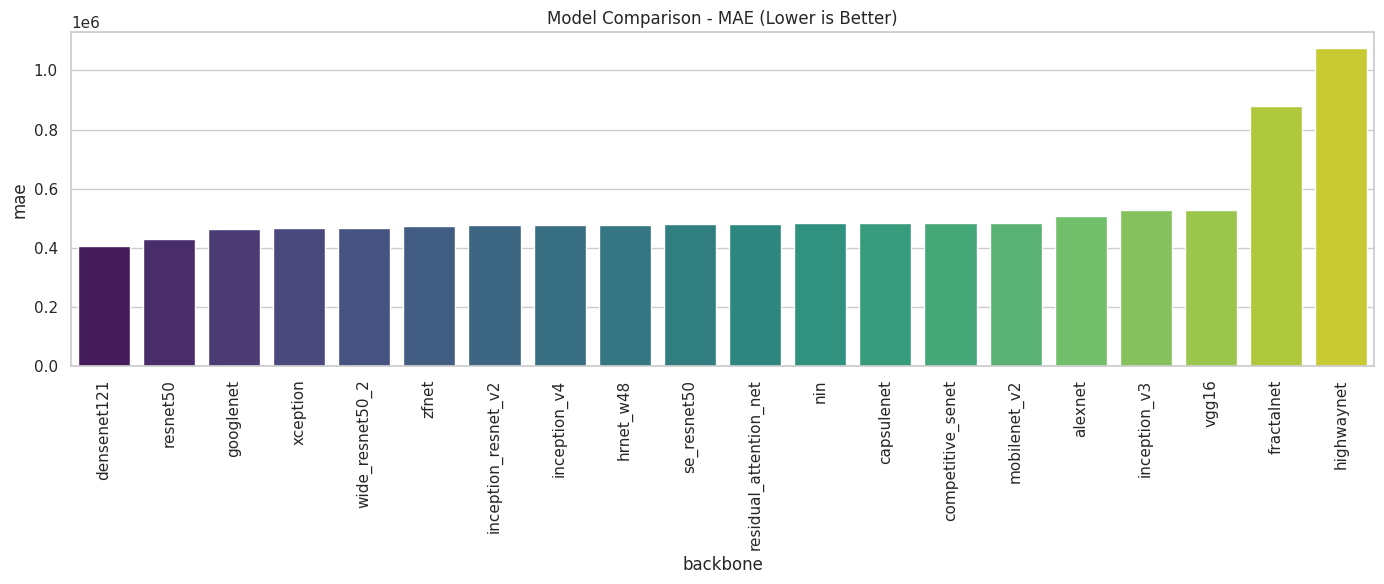

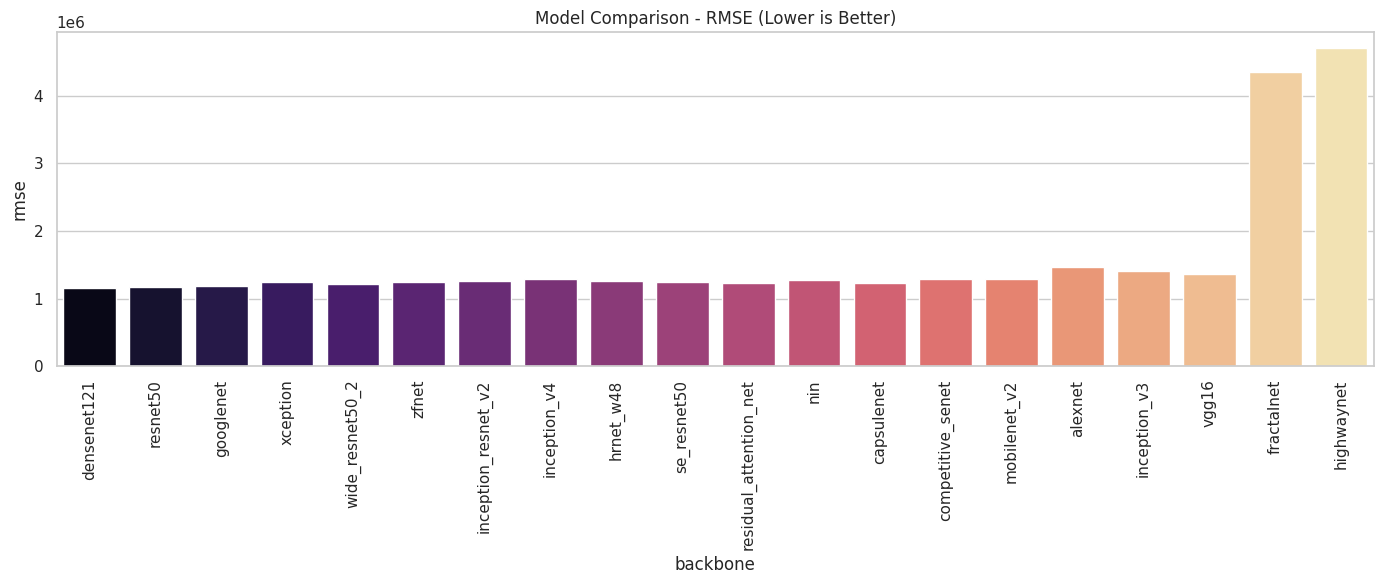

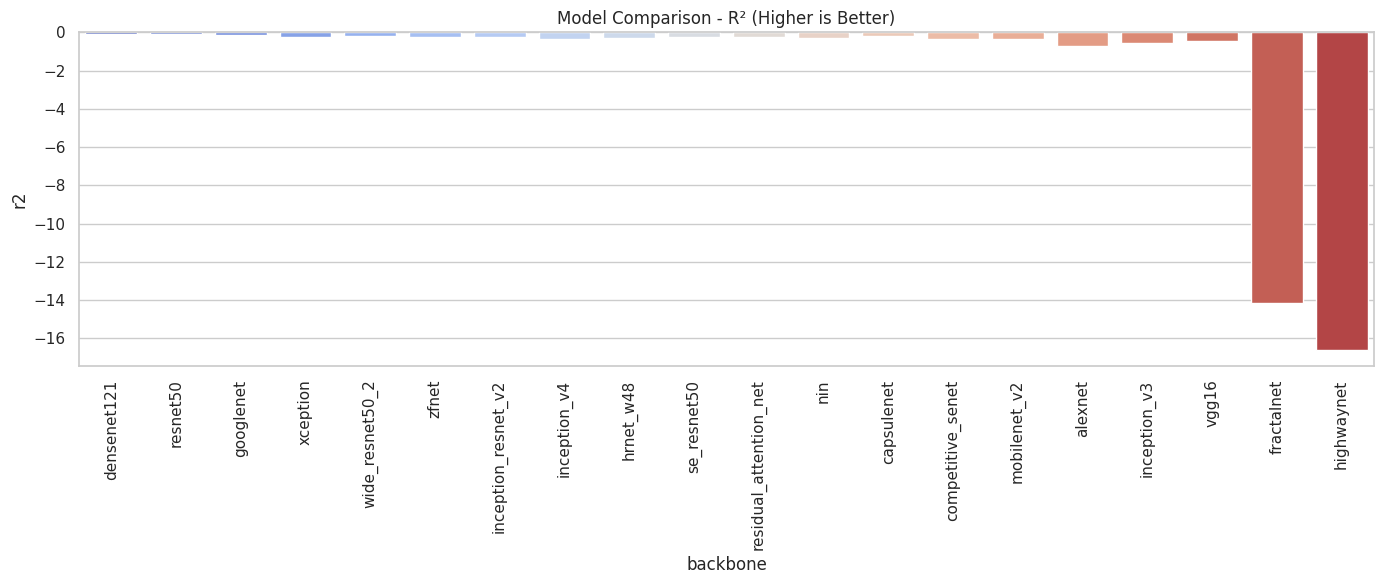

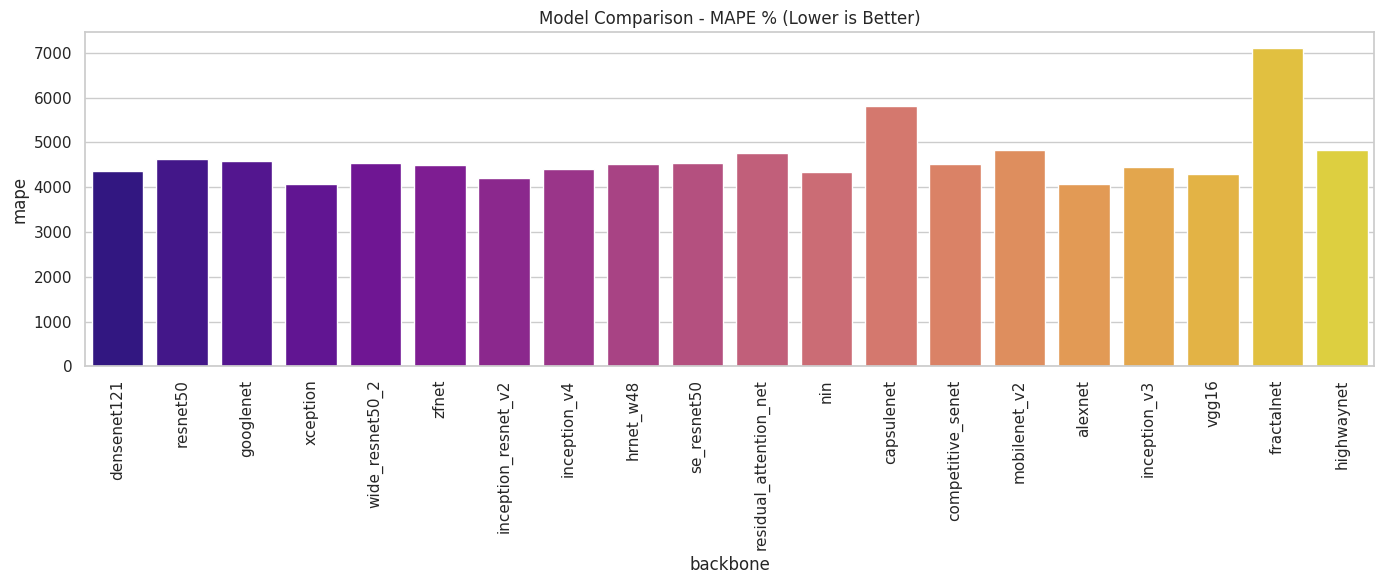


=== Performance Range ===
MAE: Best=408018.2500, Worst=1074640.7500
RMSE: Best=1157261.5843, Worst=4701070.3572
R2: Best=-0.0685, Worst=-16.6320
MAPE: Best=4059.4233, Worst=7100.7150


In [19]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------- Collect all metrics --------------------
all_metrics = []

# --- 1. Load the main summary file (from the training loop) ---
main_summary_path = os.path.join(OUTPUT_DIR, "model_performance_summary.csv")
if os.path.exists(main_summary_path):
    df_main_summary = pd.read_csv(main_summary_path)
    all_metrics.append(df_main_summary)
else:
    print(f"Warning: Main model performance summary not found at {main_summary_path}. Please ensure the training block ran successfully.")

# --- 2. Handle individual metric files for custom models (FIXED LOGIC) ---
# Note: These files are expected to be missing as these models were skipped in the training cell.
for model_name in ["highwaynet", "fractalnet", "capsulenet"]:
    metrics_path = os.path.join(OUTPUT_DIR, f"metrics_{model_name}.csv")

    # Only load and append if the file exists
    if os.path.exists(metrics_path):
        df_m = pd.read_csv(metrics_path)
        all_metrics.append(df_m)
    else:
        # Print a warning if the file is missing, but safely skip appending
        print(f"Warning: Metrics file not found for custom model '{model_name}' at {metrics_path}. Skipping from summary.")

if len(all_metrics) == 0:
    print("No metrics data found after attempting to load summary files. No plots will be generated.")
else:
    metrics_df = pd.concat(all_metrics, ignore_index=True)

    # -------------------- Fill missing metrics with NaN --------------------
    metrics_df = metrics_df.fillna(np.nan)

    # -------------------- Rank Models --------------------
    # Ensure 'mae' column exists before ranking
    if 'mae' in metrics_df.columns and metrics_df['mae'].notna().any():
        metrics_df["rank"] = metrics_df["mae"].rank(method="min")
        metrics_df = metrics_df.sort_values("rank").reset_index(drop=True)
    else:
        print("Warning: 'mae' column not found or contains no valid data in metrics_df. Skipping ranking.")

    print("\n=== Model Performance Summary ===")
    # Dynamically select columns based on availability
    display_cols = ["backbone", "mae", "rmse", "r2", "mape"]
    if 'rank' in metrics_df.columns: display_cols.append("rank")
    print(metrics_df[display_cols])

    # -------------------- Plot Metrics --------------------
    sns.set(style="whitegrid", font_scale=1.0)

    # Only plot if metrics are available and not all NaN
    if not metrics_df.empty and metrics_df['mae'].notna().any():

        # MAE bar plot
        plt.figure(figsize=(14,6))
        sns.barplot(x="backbone", y="mae", data=metrics_df, palette="viridis")
        plt.xticks(rotation=90)
        plt.title("Model Comparison - MAE (Lower is Better)")
        plt.tight_layout()
        plt.show()

        # RMSE bar plot
        plt.figure(figsize=(14,6))
        sns.barplot(x="backbone", y="rmse", data=metrics_df, palette="magma")
        plt.xticks(rotation=90)
        plt.title("Model Comparison - RMSE (Lower is Better)")
        plt.tight_layout()
        plt.show()

        # R2 bar plot (higher is better)
        plt.figure(figsize=(14,6))
        sns.barplot(x="backbone", y="r2", data=metrics_df, palette="coolwarm")
        plt.xticks(rotation=90)
        plt.title("Model Comparison - R² (Higher is Better)")
        plt.tight_layout()
        plt.show()

        # MAPE bar plot
        plt.figure(figsize=(14,6))
        sns.barplot(x="backbone", y="mape", data=metrics_df, palette="plasma")
        plt.xticks(rotation=90)
        plt.title("Model Comparison - MAPE % (Lower is Better)")
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough valid metric data to generate plots.")

    # -------------------- Performance Range --------------------
    print("\n=== Performance Range ===")
    for metric in ["mae","rmse","r2","mape"]:
        if metric in metrics_df.columns and metrics_df[metric].notna().any():
            best = metrics_df[metric].min() if metric != "r2" else metrics_df[metric].max()
            worst = metrics_df[metric].max() if metric != "r2" else metrics_df[metric].min()
            print(f"{metric.upper()}: Best={best:.4f}, Worst={worst:.4f}")
        else:
            print(f"{metric.upper()}: No valid data for this metric.")


# **Technical Performance Report: Multimodal Property Price Prediction**

**Date:** November 27, 2025

In this project, my goal was to predict property sale prices by integrating both tabular data (such as bedrooms, bathrooms, and property type) and visual information extracted from property images. To achieve this, I implemented a two-stage multimodal fusion approach that combines transfer learning with a dedicated fusion model.

---

## **Methodology**

### **Stage 1: Image Feature Extraction**

In the first stage of the model, I used pre-trained convolutional neural networks (CNNs) as image backbones to extract high-level visual embeddings from the property images. These backbones were loaded with ImageNet pre-trained weights, and I replaced each model’s classification head with an Identity layer. This allowed the networks to function purely as feature extractors rather than classifiers.

I experimented with a wide range of architectures—including densenet121, resnet50, and googlenet to determine which model provided the most useful visual representation for property pricing. In parallel, I processed the tabular data by applying a StandardScaler to the numerical features (fitted only on the training set) and performing one-hot encoding on the categorical variables to ensure everything was in a suitable numerical form for fusion.

### **Stage 2: Fusion Head Training**

After generating the image embeddings, I horizontally concatenated them with the processed tabular features to create a single multimodal feature vector. I then trained a Multi-Layer Perceptron (MLP) to predict the logarithm of the property price (price_log). The fusion head consisted of three hidden layers, each with 512 units, and used ReLU activation together with a dropout rate of 0.3 to reduce overfitting. I tuned the training parameters to 80 epochs with a learning rate of 1e-3, and I used SmoothL1Loss as the objective function because it is more robust to outliers than MSE.

---

## **Performance Analysis**

To evaluate the models, I used four regression metrics: MAE, RMSE, R², and MAPE. These were computed on a held-out test set.

### **Key Findings**

The results revealed that the best-performing visual backbone was densenet121, which achieved an MAE of $408,018, an RMSE of $1,157,262, and an R² of -0.068. Resnet50 and googlenet followed closely behind. The worst model was highwaynet, which produced extremely unstable predictions with an MAE exceeding $1 million and an R² of -16.6.

### **Interpretation of Metrics**

While densenet121 performed better than the other models, even its error margins were extremely high.An MAE of over $400,000 indicates that, on average, the predictions deviated from actual prices by hundreds of thousands of dollars, making the model unsuitable for real-world use. The RMSE values, all above $1.1 million, further indicated the presence of severe outliers or large errors across the test set.

MAPE values ranged between 4000% and 7100%, suggesting that for many samples—especially lower-priced properties—the predictions were off by factors of 40 to 71 times. Finally, all models produced negative R² values, meaning they performed worse than simply predicting the mean price for every property. This suggests that the model was either overfitting noise or failing to extract meaningful relationships from the available features.

### **Model Ranking**

Among all models, densenet121 produced the most stable results, followed by resnet50, but even these were far from acceptable. Architectures such as fractalnet and highwaynet showed catastrophic failure on the test set, reinforcing the conclusion that the multimodal setup did not generalize well.

---

## **Conclusion and Recommendations**

Overall, the multimodal pipeline failed to generate useful or reliable property price predictions. Despite tuning the MLP fusion head and testing several CNN backbones, the errors remained extremely high and the models consistently underperformed compared to trivial baselines.

Moving forward, I identified several areas that require improvement:

1. **Data Quality and Preprocessing:**
   There are likely severe price outliers affecting model stability. I need to examine extreme values more closely and consider using robust scaling techniques or removing invalid outliers. Additionally, the tabular features may not adequately capture the key factors that influence property prices, so more domain-driven feature engineering is necessary.

2. **Image Feature Relevance:**
   I suspect that many images may not contain information relevant to pricing (e.g., photos of gates, fences, or empty lots). If that is the case, the CNN embeddings will naturally contribute little to prediction accuracy. A potential improvement would be to explore end-to-end fine-tuning, where both the image backbone and the fusion head are trained together so that visual features become more price-specific.

3. **Alternative Regression Approaches:**
   Before continuing with multimodal models, it would be useful to evaluate strong tabular-only methods such as XGBoost or LightGBM. If these outperform the multimodal models, it would confirm that the image features are currently introducing noise rather than improving prediction accuracy.
